In [1]:
import tensorflow as tf
from tensorflow import keras

import math
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 16
})

SAVE_FIG = True

def save_fig(name, tight_layout = True):
    if SAVE_FIG:
        if not os.path.isdir("plots"):
            os.mkdir("plots")
        print(f"Saving figure {name} ...")
        if tight_layout:
            plt.tight_layout(pad=0.5)
        plt.savefig(f"plots/{name}.pdf", backend="pgf")

In [2]:
print(tf.__version__)

2.5.0


In [3]:
xs = tf.linspace(0, 14, 4000)
ys = tf.math.sin(xs)

Saving figure sine-curve ...


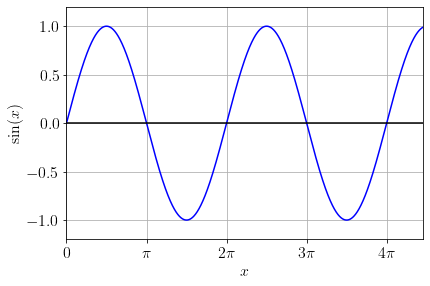

In [4]:
plt.plot(xs, ys, "b-")
plt.plot()
plt.grid()
plt.plot([-10, 20], [0, 0], "k-")
plt.axis([0, 14, -1.2, 1.2])
plt.xlabel("$x$")
plt.ylabel("$\sin(x)$")
plt.xticks(tf.range(0, 5 * math.pi, math.pi), ["0", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"])
save_fig("sine-curve")
plt.show()

Saving figure sine-data ...


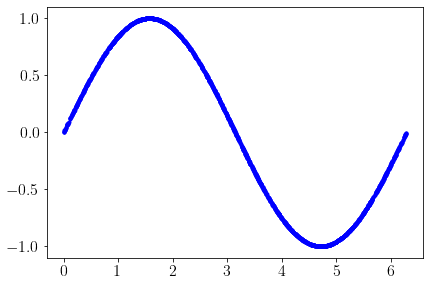

In [5]:
SAMPLES = 2000

tf.random.set_seed(42)

x = tf.random.uniform((SAMPLES, 1), minval=0, maxval=2*math.pi)

tf.random.shuffle(x)

y = tf.math.sin(x)

plt.plot(x, y, "b.")
save_fig("sine-data")
plt.show()

Saving figure sine-data-noise ...


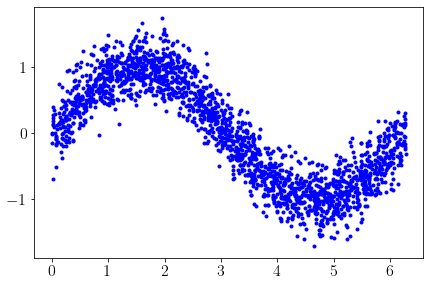

In [6]:
y += 0.25 * tf.random.normal(y.shape)
plt.plot(x, y, "b.")
save_fig("sine-data-noise")
plt.show()

Saving figure over_underfitting ...


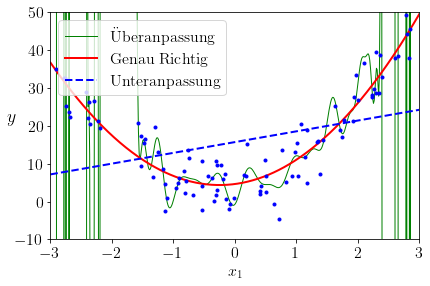

In [7]:
def plot_over_underfitting():
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures

    x = tf.random.uniform((100, 1), minval=-3, maxval=3)
    y = 5 + 2*x + 4*(x**2) + 5 * tf.random.normal((100, 1))

    x_new = tf.linspace([-3], [3], 500)

    features = (
        ("g-", 1, 300, "Überanpassung"),
        ("r-", 2, 2, "Genau Richtig"),
        ("b--", 2, 1, "Unteranpassung")
    )
    
    for style, width, degree, label in features:
        polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
        std_scaler = StandardScaler()
        lin_reg = LinearRegression()
        polynomial_regression = Pipeline([
                ("poly_features", polybig_features),
                ("std_scaler", std_scaler),
                ("lin_reg", lin_reg),
            ])
        polynomial_regression.fit(x, y)
        y_new = polynomial_regression.predict(x_new)
        plt.plot(x_new, y_new, style, label=label, linewidth=width)

    plt.plot(x, y, "b.", linewidth=3)
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.ylabel("$y$", rotation=0, fontsize=18)
    plt.axis([-3, 3, -10, 50])
    save_fig("over_underfitting")
    plt.show()

plot_over_underfitting()

In [8]:
TRAIN_SIZE = int(0.5 * SAMPLES)
TEST_SIZE = int(0.3 * SAMPLES)
VAL_SIZE = SAMPLES - TRAIN_SIZE - TEST_SIZE

x_train, x_test, x_val = tf.split(x, [TRAIN_SIZE, TEST_SIZE, VAL_SIZE])
y_train, y_test, y_val = tf.split(y, [TRAIN_SIZE, TEST_SIZE, VAL_SIZE])

assert tf.size(x_train) + tf.size(x_test) + tf.size(x_val) == SAMPLES

Saving figure sine-data-noise-split ...


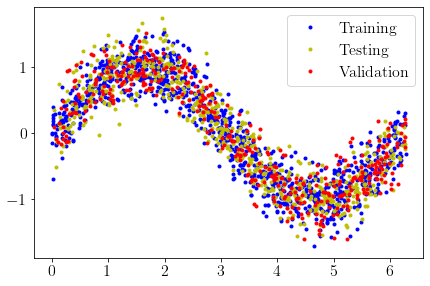

In [9]:
plt.plot(x_train, y_train, "b.", label="Training")
plt.plot(x_test, y_test, "y.", label="Testing")
plt.plot(x_val, y_val, "r.", label="Validation")
plt.legend(loc="upper right")
save_fig("sine-data-noise-split")
plt.show()

Saving figure activation-functions ...


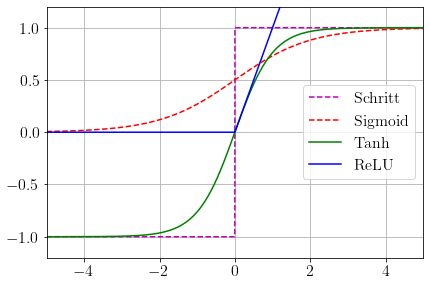

In [10]:
def plot_activation_functions():
    z = tf.linspace(-6, 6, 3000)

    def relu(z):
        x = tf.constant(0, dtype=z.dtype),
        return tf.maximum(x, z)
    
    def sigmoid(z):
        return 1 / (1 + tf.math.exp(-z))

    def tanh(z):
        return 2 * sigmoid(2 * z) - 1

    def step(z):
        return tf.map_fn(lambda t: -1 if t < 0 else 1, z)

    plt.plot(z, step(z), "m--", label="Schritt")
    plt.plot(z, sigmoid(z), "r--", label="Sigmoid")
    plt.plot(z, tanh(z), "g-", label="Tanh")
    plt.plot(z, relu(z), "b-", label="ReLU")
    plt.grid()
    plt.axis([-5, 5, -1.2, 1.2])
    plt.legend(loc="center right")
    save_fig("activation-functions")
    plt.show()

plot_activation_functions()

In [11]:
input_layer = keras.layers.Input(shape=[1])
hidden1 = keras.layers.Dense(16, activation="relu")(input_layer)
output_layer = keras.layers.Dense(1, name="output")(hidden1)

model_1 = keras.Model(inputs=input_layer, outputs=output_layer)

In [12]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                32        
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_1.layers

In [14]:
hidden1 = model_1.layers[1]
print(hidden1.name)
print(model_1.get_layer("dense") is hidden1)

dense
True


In [15]:
weights, biases = hidden1.get_weights()

In [16]:
weights

array([[ 0.5445634 , -0.5741172 , -0.2190957 , -0.40382388,  0.25530386,
         0.34373027, -0.45763797, -0.1983017 , -0.3434852 ,  0.14649397,
         0.57805157, -0.4487671 , -0.34861064,  0.44097137, -0.5695514 ,
        -0.33477765]], dtype=float32)

In [17]:
weights.shape

(1, 16)

In [18]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [19]:
biases.shape

(16,)

In [20]:
sgd = tf.keras.optimizers.SGD()
model_1.compile(optimizer=sgd, loss="mse", metrics=["mae"])

In [21]:
EPOCHS = 300
BATCH_SIZE = 16
history_1 = model_1.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))

Epoch 1/300
63/63 [==============================] - 1s 3ms/step - loss: 0.5319 - mae: 0.6028 - val_loss: 0.3661 - val_mae: 0.5134
Epoch 2/300
63/63 [==============================] - 0s 2ms/step - loss: 0.3422 - mae: 0.4941 - val_loss: 0.2898 - val_mae: 0.4533
Epoch 3/300
63/63 [==============================] - 0s 2ms/step - loss: 0.2857 - mae: 0.4520 - val_loss: 0.2566 - val_mae: 0.4267
Epoch 4/300
63/63 [==============================] - 0s 2ms/step - loss: 0.2656 - mae: 0.4321 - val_loss: 0.2454 - val_mae: 0.4150
Epoch 5/300
63/63 [==============================] - 0s 2ms/step - loss: 0.2513 - mae: 0.4178 - val_loss: 0.2594 - val_mae: 0.4196
Epoch 6/300
63/63 [==============================] - 0s 2ms/step - loss: 0.2429 - mae: 0.4089 - val_loss: 0.2464 - val_mae: 0.4077
Epoch 7/300
63/63 [==============================] - 0s 2ms/step - loss: 0.2412 - mae: 0.4079 - val_loss: 0.2998 - val_mae: 0.4403
Epoch 8/300
63/63 [==============================] - 0s 2ms/step - loss: 0.2389 - m

In [22]:
x_train.shape

TensorShape([1000, 1])

In [23]:
hidden1 = model_1.get_layer("dense")
weights, biases = hidden1.get_weights()

In [24]:
weights

array([[ 0.48667273, -0.5741172 , -0.2190957 , -0.40382388,  0.4334338 ,
         0.23612384, -0.45763797, -0.1983017 , -0.3434852 ,  0.7860138 ,
         0.55660063, -0.4487671 , -0.34861064,  0.41839588, -0.5695514 ,
        -0.33477765]], dtype=float32)

In [25]:
biases

array([-0.65050036,  0.        ,  0.        ,  0.        , -0.574309  ,
       -0.00350828,  0.        ,  0.        ,  0.        , -0.97527707,
       -0.00748958,  0.        ,  0.        , -0.00579906,  0.        ,
        0.        ], dtype=float32)

In [26]:
history_1.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [27]:
mse_1 = history_1.history["loss"]
val_mse_1 = history_1.history["val_loss"]
mae_1 = history_1.history["mae"]
val_mae_1 = history_1.history["val_mae"]
assert len(mse_1) == len(val_mse_1) == EPOCHS
assert len(mae_1) == len(val_mae_1) == EPOCHS

Saving figure 1-metrics-small ...


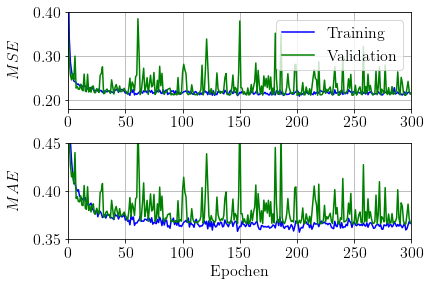

In [28]:
from matplotlib.ticker import StrMethodFormatter

epochs = tf.range(0.0, EPOCHS)

plt.subplot(211)
plt.plot(epochs, mse_1, "b-", label="Training")
plt.plot(epochs, val_mse_1, "g-", label="Validation")
plt.grid()
plt.ylabel("$MSE$", labelpad=12)
plt.legend(loc="upper right")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.axis([0, EPOCHS, 0.18, 0.4])

plt.subplot(212)
plt.plot(epochs, mae_1, "b-", label="Training")
plt.plot(epochs, val_mae_1, "g-", label="Validation")
plt.grid()
plt.xlabel("Epochen")
plt.ylabel("$MAE$", labelpad=12)
plt.axis([0, EPOCHS, 0.35, 0.45])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
save_fig("1-metrics-small")
plt.show()

Saving figure 1-metrics ...


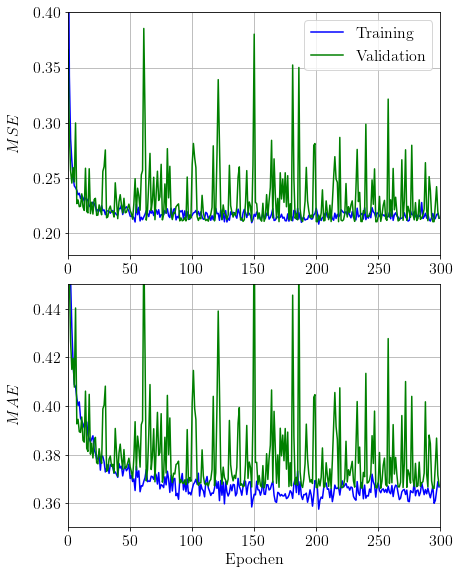

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[6.4, 8])

ax1.plot(epochs, mse_1, "b-", label="Training")
ax1.plot(epochs, val_mse_1, "g-", label="Validation")
ax1.grid()
ax1.set_ylabel("$MSE$", labelpad=12)
ax1.legend(loc="upper right")
ax1.axis([0, EPOCHS, 0.18, 0.4])

ax2.plot(epochs, mae_1, "b-", label="Training")
ax2.plot(epochs, val_mae_1, "g-", label="Validation")
ax2.grid()
ax2.set_xlabel("Epochen")
ax2.set_ylabel("$MAE$", labelpad=12)
ax2.axis([0, EPOCHS, 0.35, 0.45])
save_fig("1-metrics")
plt.show()

Saving figure 1-predictions_val ...


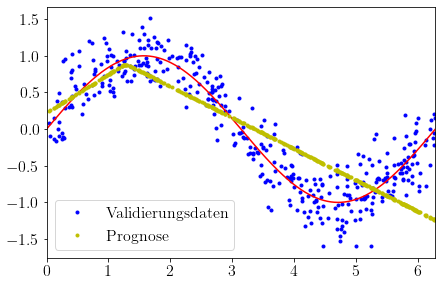

In [30]:
predictions_1 = model_1.predict(x_val)

plt.plot(x_val, y_val, "b.", label="Validierungsdaten")
plt.plot(xs, ys, "r-")
plt.plot(x_val, predictions_1, "y.", label="Prognose")
plt.xlim([0, 2*math.pi])
plt.legend()
save_fig(f"1-predictions_val")
plt.show()

In [31]:
input_layer = keras.Input(shape=[1])
hidden1 = keras.layers.Dense(8, activation="relu")(input_layer)
hidden2 = keras.layers.Dense(16, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(32, activation="relu")(hidden2)
output_layer = keras.layers.Dense(1, name="output")(hidden3)

model_2 = keras.Model(inputs=input_layer, outputs=output_layer)

In [32]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [33]:
sgd = tf.keras.optimizers.SGD()
model_2.compile(optimizer=sgd, loss="mse", metrics=["mae"])

In [34]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=EPOCHS,
    monitor="loss",
    verbose=1,
    restore_best_weights=True)

history_2 = model_2.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val))

Epoch 1/300
63/63 [==============================] - 0s 4ms/step - loss: 0.4988 - mae: 0.6041 - val_loss: 0.3944 - val_mae: 0.5356
Epoch 2/300
63/63 [==============================] - 0s 2ms/step - loss: 0.3581 - mae: 0.5049 - val_loss: 0.3006 - val_mae: 0.4644
Epoch 3/300
63/63 [==============================] - 0s 3ms/step - loss: 0.2858 - mae: 0.4506 - val_loss: 0.2518 - val_mae: 0.4224
Epoch 4/300
63/63 [==============================] - 0s 2ms/step - loss: 0.2519 - mae: 0.4208 - val_loss: 0.2302 - val_mae: 0.4015
Epoch 5/300
63/63 [==============================] - 0s 3ms/step - loss: 0.2339 - mae: 0.4022 - val_loss: 0.2252 - val_mae: 0.3932
Epoch 6/300
63/63 [==============================] - 0s 3ms/step - loss: 0.2255 - mae: 0.3917 - val_loss: 0.2196 - val_mae: 0.3857
Epoch 7/300
63/63 [==============================] - 0s 2ms/step - loss: 0.2218 - mae: 0.3883 - val_loss: 0.2474 - val_mae: 0.4013
Epoch 8/300
63/63 [==============================] - 0s 2ms/step - loss: 0.2206 - m

In [35]:
mse_2 = history_2.history["loss"]
val_mse_2 = history_2.history["val_loss"]
mae_2 = history_2.history["mae"]
val_mae_2 = history_2.history["val_mae"]
assert len(mse_2) == len(val_mse_2) == EPOCHS
assert len(mae_2) == len(val_mae_2) == EPOCHS

Saving figure 2-mse ...


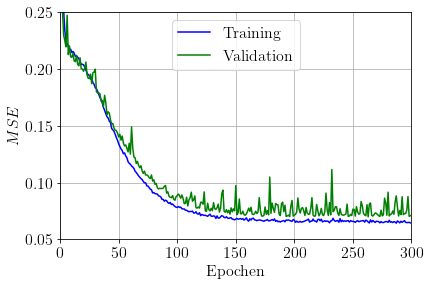

Saving figure 2-mae ...


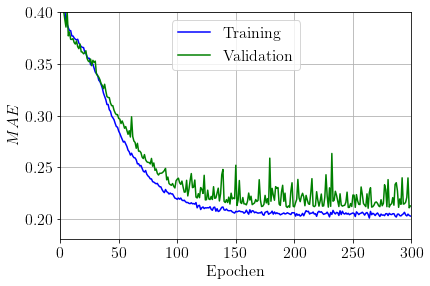

In [36]:
epochs = tf.range(0.0, EPOCHS)

plt.plot(epochs, mse_2, "b-", label="Training")
plt.plot(epochs, val_mse_2, "g-", label="Validation")
plt.grid()
plt.xlabel("Epochen")
plt.ylabel("$MSE$")
plt.legend(loc="upper center")
plt.axis([0, EPOCHS, 0.05, 0.25])
save_fig("2-mse")
plt.show()

plt.plot(epochs, mae_2, "b-", label="Training")
plt.plot(epochs, val_mae_2, "g-", label="Validation")
plt.grid()
plt.xlabel("Epochen")
plt.ylabel("$MAE$")
plt.legend(loc="upper center")
plt.axis([0, EPOCHS, 0.18, 0.4])
save_fig("2-mae")
plt.show()

Saving figure 2-metrics ...


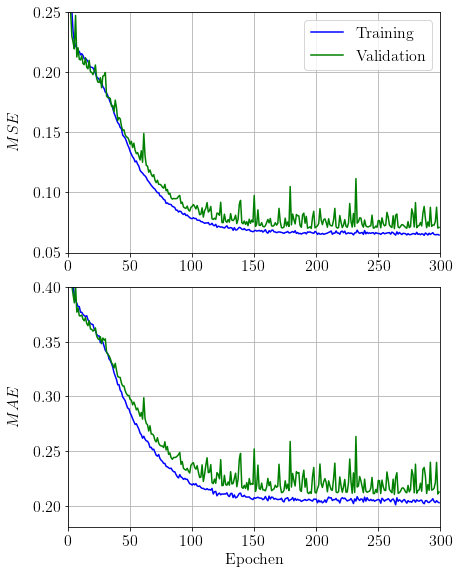

In [37]:
epochs = tf.range(0.0, EPOCHS)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[6.4, 8])

ax1.plot(epochs, mse_2, "b-", label="Training")
ax1.plot(epochs, val_mse_2, "g-", label="Validation")
ax1.grid()
ax1.set_ylabel("$MSE$", labelpad=12)
ax1.legend(loc="upper right")
ax1.set_yticks(tf.range(0.05, 0.30, delta=0.05))
ax1.axis([0, EPOCHS, 0.05, 0.25])

ax2.plot(epochs, mae_2, "b-", label="Training")
ax2.plot(epochs, val_mae_2, "g-", label="Validation")
ax2.grid()
ax2.set_xlabel("Epochen")
ax2.set_ylabel("$MAE$", labelpad=12)
ax2.axis([0, EPOCHS, 0.18, 0.4])
save_fig("2-metrics")
plt.show()

In [38]:
model_2.evaluate(x_test, y_test)

19/19 [==============================] - 0s 2ms/step - loss: 0.0707 - mae: 0.2078


[0.07067134976387024, 0.20784439146518707]

Saving figure 2-predictions_val ...


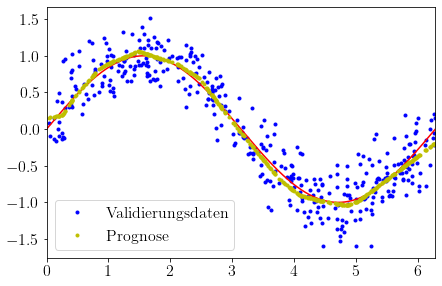

In [39]:
predictions_2 = model_2.predict(x_val)
plt.plot(x_val, y_val, "b.", label="Validierungsdaten")
plt.plot(xs, ys, "r-")
plt.plot(x_val, predictions_2, "y.", label="Prognose")
plt.xlim([0, 2*math.pi])
plt.legend()
save_fig("2-predictions_val")
plt.show()

Saving figure 2-predictions ...


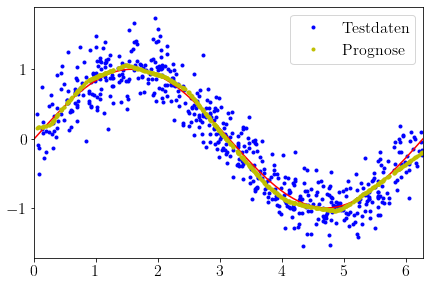

In [40]:
predictions_2 = model_2.predict(x_test)
plt.plot(x_test, y_test, "b.", label="Testdaten")
plt.plot(xs, ys, "r-")
plt.plot(x_test, predictions_2, "y.", label="Prognose")
plt.xlim([0, 2*math.pi])
plt.legend()
save_fig("2-predictions")
plt.show()

In [41]:
model_2.evaluate(x_test, y_test)

19/19 [==============================] - 0s 1ms/step - loss: 0.0707 - mae: 0.2078


[0.07067134976387024, 0.20784439146518707]

In [42]:
model_2.save("sine_model.h5")

In [43]:
def save_model(model, model_name):
    with open(model_name, "wb") as f:
        f.write(model)

In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

save_model(tflite_model, "sine_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\jens\AppData\Local\Temp\tmppukygj34\assets


In [45]:
import os

kB = lambda n: f"({n / 1024:.2f} kB)"
sine_original_size = os.path.getsize("sine_model.h5")
sine_lite_size = os.path.getsize("sine_model.tflite")
print(f"Ursprüngliche Größe: {sine_original_size} bytes")
print(f"TFLite Größe: {sine_lite_size} bytes")
print(f"Differenz: {sine_original_size - sine_lite_size} bytes")

Ursprüngliche Größe: 25480 bytes
TFLite Größe: 4856 bytes
Differenz: 20624 bytes


In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset():
    for value in x_test:
        yield [value]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model = converter.convert()

save_model(tflite_model, "sine_model_quant.tflite")

INFO:tensorflow:Assets written to: C:\Users\jens\AppData\Local\Temp\tmp2yx_paco\assets


INFO:tensorflow:Assets written to: C:\Users\jens\AppData\Local\Temp\tmp2yx_paco\assets


In [47]:
sine_lite_quant_size = os.path.getsize("sine_model_quant.tflite")
print(f"TFLite Größe: {sine_lite_size} bytes")
print(f"TFLite + Quantisierung Größe: {sine_lite_quant_size} bytes")
print(f"Differenz: {sine_lite_size - sine_lite_quant_size} bytes")

TFLite Größe: 4856 bytes
TFLite + Quantisierung Größe: 3280 bytes
Differenz: 1576 bytes


In [48]:
import platform

EDGETUP_LIB = {
    "Linux": "libedgetpu.so.1",
    "Darwin": "libedgetpu.1.dylib",
    "Windows": "edgetpu.dll",
}[platform.system()]

delegates = [tf.lite.experimental.load_delegate(EDGETUP_LIB)]

sine_model_cpu = tf.lite.Interpreter("sine_model.tflite")
sine_model_tpu = tf.lite.Interpreter(
    "sine_model_quant_edgetpu.tflite",
    experimental_delegates=delegates
)

In [49]:
sine_model_cpu.get_input_details()

[{'name': 'input_2',
  'index': 0,
  'shape': array([1, 1]),
  'shape_signature': array([-1,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [50]:
sine_model_cpu.get_output_details()

[{'name': 'Identity',
  'index': 12,
  'shape': array([1, 1]),
  'shape_signature': array([-1,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [51]:
sine_model_tpu.get_input_details()

[{'name': 'input_2',
  'index': 0,
  'shape': array([1, 1]),
  'shape_signature': array([1, 1]),
  'dtype': numpy.int8,
  'quantization': (0.024590179324150085, -128),
  'quantization_parameters': {'scales': array([0.02459018], dtype=float32),
   'zero_points': array([-128]),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [52]:
sine_model_tpu.get_output_details()

[{'name': 'Identity',
  'index': 1,
  'shape': array([1, 1]),
  'shape_signature': array([1, 1]),
  'dtype': numpy.int8,
  'quantization': (0.00822637788951397, -2),
  'quantization_parameters': {'scales': array([0.00822638], dtype=float32),
   'zero_points': array([-2]),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [53]:
sine_model_tpu.get_output_details()[0].keys()

dict_keys(['name', 'index', 'shape', 'shape_signature', 'dtype', 'quantization', 'quantization_parameters', 'sparsity_parameters'])

In [54]:
sine_model_cpu.allocate_tensors()
sine_model_tpu.allocate_tensors()

input_details_cpu = sine_model_cpu.get_input_details()[0]
input_details_tpu = sine_model_tpu.get_input_details()[0]

output_details_cpu = sine_model_cpu.get_output_details()[0]
output_details_tpu = sine_model_tpu.get_output_details()[0]

input_scale, input_zero_point = input_details_tpu["quantization"]
output_scale, output_zero_point = output_details_tpu["quantization"]

input_index_cpu = input_details_cpu["index"]
input_index_tpu = input_details_tpu["index"]

output_index_cpu = output_details_cpu["index"]
output_index_tpu = output_details_tpu["index"]

sine_model_cpu_predictions = []
sine_model_tpu_predictions = []

for value in x_test:
    float32_tensor = tf.expand_dims(value, axis=0)
    # q = r / S + Z
    int8_tensor = value / input_scale + input_zero_point
    int8_tensor = tf.cast(int8_tensor, dtype=tf.int8)
    int8_tensor = tf.expand_dims(int8_tensor, axis=0)
    
    sine_model_cpu.set_tensor(input_index_cpu, float32_tensor)
    sine_model_tpu.set_tensor(input_index_tpu, int8_tensor)

    sine_model_cpu.invoke()
    sine_model_tpu.invoke()
    
    output = sine_model_cpu.get_tensor(output_index_cpu)[0,0]
    sine_model_cpu_predictions.append(output)
    output = sine_model_tpu.get_tensor(output_index_tpu)[0,0]
    # r = S(q − Z)
    output = output_scale * (output - output_zero_point) 
    sine_model_tpu_predictions.append(output)

Saving figure model-comparison ...


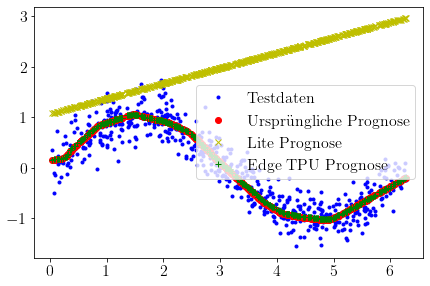

In [55]:
plt.plot(x_test, y_test, "b.", label="Testdaten")
plt.plot(x_test, predictions_2, "ro", label="Ursprüngliche Prognose")
plt.plot(x_test, sine_model_cpu_predictions, "yx", label="Lite Prognose")
plt.plot(x_test, sine_model_tpu_predictions, "g+", label="Edge TPU Prognose")
plt.legend()
save_fig("model-comparison")
plt.show()

In [56]:
import os
sine_original_size = os.path.getsize("sine_model.h5")
print(f"Sine model original size: {sine_original_size}")
sine_size = os.path.getsize("sine_model.tflite")
print(f"Sine model size: {sine_size}")
sine_quant_size = os.path.getsize("sine_model_quant.tflite")
print(f"Sine model quant size: {sine_quant_size}")
sine_tpu_size = os.path.getsize("sine_model_quant_edgetpu.tflite")
print(f"Sine model Edge TPU size: {sine_tpu_size}")

Sine model original size: 25480
Sine model size: 4856
Sine model quant size: 3280
Sine model Edge TPU size: 37440


In [57]:
import pathlib
import tarfile

path = pathlib.Path()
with tarfile.open("sine_models.tar.gz", "w:gz") as tar:
    for model in path.glob("sine_model*.tflite"):
        if model.is_file():
            tar.add(model.name)